In [1]:
import numpy as np
import cupy as cp
from numba import jit, prange
import timeit
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from cupyx.scipy.sparse import coo_matrix as cp_coo_matrix

import sys
sys.path.append('../..')
from epipy.sparse import rigid_csr_matrix

In [2]:
def ss_base(mat1, mat2, c):
    res = mat1 + (mat2-mat1)*c
    
def ss_cp(mat1, mat2, c):
    res = mat1 + (mat2-mat1)*c
    
# Deprecated
# def ss_nb(A, iA, jA, B, iB, jB, c, C, iC, jC):
#     n = len(iA) - 1
#     for row in prange(n):
#         for i in prange(iB[row], iB[row+1]):
#             left = int(iA[row])
#             right = int(iA[row+1]-1)
#             while left <= right:
#                 mid = int((left+right) / 2)
#                 if jA[mid] < jB[i]:
#                     left = mid + 1
#                 elif jA[mid] > jB[i]:
#                     right = mid - 1
#                 else:
#                     # jA[mid] == jB[i]
#                     C[mid] += B[i]*c
#                     break    

def ss_nb(mat, values, row, col, c):
    res_mat = mat.transform(values, row, col, c)

In [3]:
N = [int(8*(2**0.5)**i) for i in range(28)]
methods = ["ss_base", "ss_cp", "ss_nb"]
K = len(methods)
funcs = [ss_base, ss_cp, ss_nb]
masks = [1, 1, 1]
groups = [0, 0, 0]
T = [[] for i in range(K)]
deg = 40
obtain = 1000
for n in N:
    print("Start with size:", n)
    row, col = np.random.randint(0, n, (2, n*deg))
    data1, data2 = np.random.rand(2, n*deg)
    c = 0.75
    
    choose = np.random.randint(0, n*deg, (obtain))
    row2 = row[choose]
    col2 = col[choose]
    data2 = data2[choose]
    
    mat1 = csr_matrix((data1,(row, col)), shape=(n,n))
    cmat1 = cp_coo_matrix((cp.array(data1), (cp.array(row), cp.array(col))), shape=(n,n)).tocsr()
    mat2 = csr_matrix((data2,(row2, col2)), shape=(n,n))
    cmat2 = cp_coo_matrix((cp.array(data2), (cp.array(row2), cp.array(col2))), shape=(n,n)).tocsr()
    
    rmat = rigid_csr_matrix((data1,(row, col)), shape=(n,n))
    
    args = [(mat1, mat2, c), (cmat1, cmat2, c), (rmat, data2, row2, col2, c)]
    
    for i in range(K):
        t = %timeit -q -n 1 -r 3 -o funcs[i](*args[i])
        T[i].append(t.average*1000)

Start with size: 8
Start with size: 11
Start with size: 16
Start with size: 22
Start with size: 32
Start with size: 45
Start with size: 64
Start with size: 90
Start with size: 128
Start with size: 181
Start with size: 256
Start with size: 362
Start with size: 512
Start with size: 724
Start with size: 1024
Start with size: 1448
Start with size: 2048
Start with size: 2896
Start with size: 4096
Start with size: 5792
Start with size: 8192
Start with size: 11585
Start with size: 16384
Start with size: 23170
Start with size: 32768
Start with size: 46340
Start with size: 65536
Start with size: 92681


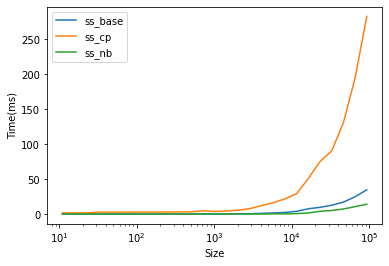

In [4]:
n_groups = max(groups)+1
fig, axs = plt.subplots(n_groups)
plt.rcParams["figure.figsize"] = (10,15)
if n_groups == 1:
    for i in range(K):
        if masks[i]:
            axs.plot(N[1:], T[i][1:], label=methods[i])
    axs.set_xlabel("Size")
    axs.set_ylabel("Time(ms)")
    axs.legend()
    axs.set_xscale('log')
else:
    for g in range(n_groups):
        for i in range(K):
            if masks[i] and groups[i] == g:
                axs[g].plot(N[1:], T[i][1:], label=methods[i])
        axs[g].set_xlabel("Size")
        axs[g].set_ylabel("Time(ms)")
        axs[g].legend()
        axs[g].set_xscale('log')
plt.show()

In [5]:
print(T)

[[0.23841299965473203, 0.22796099923046617, 0.22748133415007032, 0.21802899937028997, 0.24363166448893026, 0.22705499941366725, 0.23542699879423404, 0.24231833352435692, 0.24985133374381502, 0.258335664208668, 0.27220933164547506, 0.3055066663364414, 0.33599866704510833, 0.4842356684093829, 0.44811099966561113, 0.5178516657906584, 0.6636006667880187, 0.8433780009606077, 1.3077249993026878, 1.8628553334565368, 2.6642513330443762, 4.271837999112904, 7.868672000768129, 9.949903000233462, 12.919487332207305, 17.343330334066803, 24.983176666864892, 34.922803667238135], [4.2894523321592715, 1.9641939979919698, 2.000593999885799, 1.971941334583486, 3.0392176668101456, 3.1060009993476947, 3.0715019990263195, 3.109625665577672, 3.163380668411264, 3.1537146678601857, 3.2299890020415964, 3.3065006658337857, 3.5131653336672266, 5.050261666231866, 3.993223331538805, 4.6617989998291405, 5.877329000213649, 8.125342999846907, 12.412547333951807, 16.582388333821047, 22.1210906674969, 29.480830333341146